# Use this notebook just to fully train the models (probably should be trained on kaggle servers)

# Imports

In [2]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

import pandas as pd
import numpy as np

from IPython.display import display
from PIL import Image

import wandb
from fastai.callback.wandb import *

wandb.init(project="cassava", entity="teo03")

wandb: Currently logged in as: teo03 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.13 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Make the results reproducible

In [3]:
set_seed(420)

# Setup

In [12]:
path_str = '../data'
PATH = Path(path_str)

images_path = Path(path_str + '/train_images')
csv_path = Path(path_str + '/train.csv')
full_df = pd.read_csv(csv_path)

# Data Preprocessing

In [13]:
def get_x(row): return images_path/row['image_id']
def get_y(row): return row['label']

In [14]:
# Same as in validation

block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms=[
        Resize(384),
        FlipItem(p=0.4),
        RandomCrop(300)
    ],
    batch_tfms=[RandomResizedCropGPU(280), *aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)

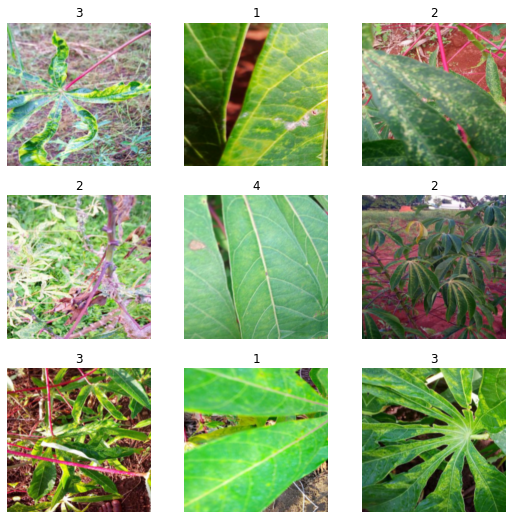

In [16]:
dls = block.dataloaders(full_df, bs=64)

dls.show_batch()

# Model and Training

In [17]:
def train(dl, arch, epochs=25, freeze_epochs=10):
    learn = cnn_learner(
        dl,
        arch,
        metrics=accuracy,
        loss_func=LabelSmoothingCrossEntropy(),
        opt_func=ranger,
        cbs=[
            WandbCallback(log_preds=True, log_model=True, n_preds=10),
            SaveModelCallback(fname=str(arch.__name__)),
        ],
    ).to_fp16()
    
    lr_min, lr_steep = learn.lr_find()
    print('found lr of: ' + str(lr_min))
    
    learn.fine_tune(epochs, base_lr=round(lr_min, 5), freeze_epochs=freeze_epochs)
    
    return learn

# Training

In [ ]:
learn = train(dls, resnet18, 1, 1)

In [14]:
learn.export(Path("fastai-model.pkl"))